# 4.4 Practical - Book Reviews

In [6]:
import pandas as pd
import numpy as np
import re
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
import transformers
from transformers import pipeline
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.model_selection import train_test_split
from sklearn import metrics
from itertools import chain
from nltk import NaiveBayesClassifier

### Load data

In [7]:
# Load dataset from CSV file (the data should be in the same folder as your notebook)
data = pd.read_csv("book_reviews_sample.csv")
data.head()

,index,reviewText,rating
0,11494,Clean and funny. A bit busy with all the diffe...,3
1,984,Alex a sexy hot cop and the PhD candidate. Wha...,4
2,1463,Good thing that this is a free story. I read i...,1
3,10342,"Action, action, action! Equipment keeps gettin...",4
4,5256,this was hands down the worse book i have ever...,1


In [8]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   index       100 non-null    int64 
 1   reviewText  100 non-null    object
 2   rating      100 non-null    int64 
dtypes: int64(2), object(1)
memory usage: 2.5+ KB


In [9]:
data['reviewText'][0]

'Clean and funny. A bit busy with all the different plots going on. But overall a good read. Bye now.'

### Clean data

In [10]:
# Lowercase
data['reviewText_clean'] = data['reviewText'].str.lower()

In [11]:
# Remove punctuation
data['reviewText_clean'] = data.apply(lambda x: re.sub(r"([^\w\s])", "", x['reviewText_clean']), axis=1)

In [12]:
data.head()

,index,reviewText,rating,reviewText_clean
0,11494,Clean and funny. A bit busy with all the diffe...,3,clean and funny a bit busy with all the differ...
1,984,Alex a sexy hot cop and the PhD candidate. Wha...,4,alex a sexy hot cop and the phd candidate what...
2,1463,Good thing that this is a free story. I read i...,1,good thing that this is a free story i read it...
3,10342,"Action, action, action! Equipment keeps gettin...",4,action action action equipment keeps getting b...
4,5256,this was hands down the worse book i have ever...,1,this was hands down the worse book i have ever...


### Rule-based sentiment with VADER

In [13]:
vader_sentiment = SentimentIntensityAnalyzer()

In [14]:
# Apply VADER and get compound score
data['vader_sentiment_score'] = data['reviewText_clean'].apply(lambda review: vader_sentiment.polarity_scores(review)['compound'])

In [15]:
data.head()

,index,reviewText,rating,reviewText_clean,vader_sentiment_score
0,11494,Clean and funny. A bit busy with all the diffe...,3,clean and funny a bit busy with all the differ...,0.7684
1,984,Alex a sexy hot cop and the PhD candidate. Wha...,4,alex a sexy hot cop and the phd candidate what...,0.9325
2,1463,Good thing that this is a free story. I read i...,1,good thing that this is a free story i read it...,0.6740
3,10342,"Action, action, action! Equipment keeps gettin...",4,action action action equipment keeps getting b...,0.6652
4,5256,this was hands down the worse book i have ever...,1,this was hands down the worse book i have ever...,-0.4767


In [16]:
# Create sentiment labels
bins = [-1, -0.1, 0.1, 1]
names = ['negative', 'neutral', 'positive']

data['vader_sentiment_label'] = pd.cut(data['vader_sentiment_score'], bins, labels=names)

<Axes: xlabel='vader_sentiment_label'>

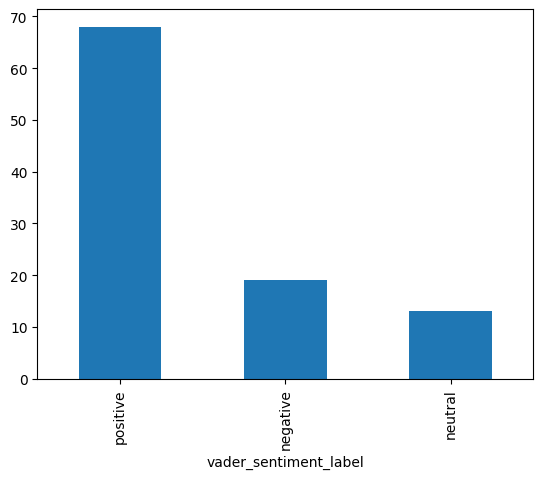

In [17]:
data['vader_sentiment_label'].value_counts().plot.bar()

### Pre-trained Transformer Model

In [18]:
transformer_pipeline = pipeline("sentiment-analysis")

No model was supplied, defaulted to distilbert/distilbert-base-uncased-finetuned-sst-2-english and revision 714eb0f (https://huggingface.co/distilbert/distilbert-base-uncased-finetuned-sst-2-english).
Using a pipeline without specifying a model name and revision in production is not recommended.
Device set to use cpu


In [ ]:
transformer_labels = []

for review in data['reviewText_clean'].values:
    sentiment_list = transformer_pipeline(review)
    sentiment_label = [sent['label'] for sent in sentiment_list]
    transformer_labels.append(sentiment_label)
    
data['transformer_sentiment_label'] = transformer_labels

<Axes: xlabel='transformer_sentiment_label'>

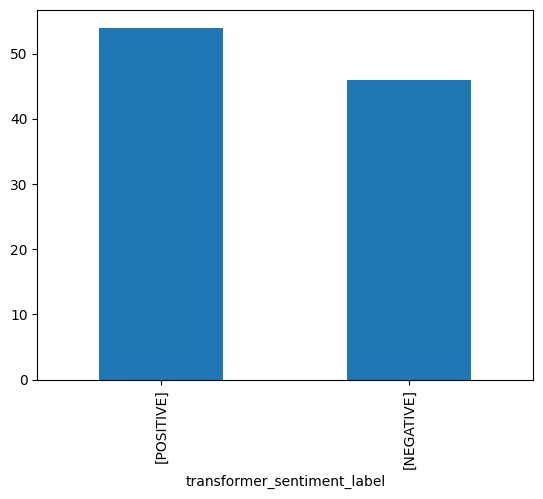

In [20]:
data['transformer_sentiment_label'].value_counts().plot.bar()

### Using trained on tweets model

In [21]:
tweet_model = pipeline("sentiment-analysis", model="finiteautomata/bertweet-base-sentiment-analysis")

Device set to use cpu


In [ ]:
bertweet_labels = []

for review in data['reviewText_clean'].values:
    sentiment_list = tweet_model(review)
    # transformer_pipeline(review) always returns a list, even for a single review, and the original code used a list comprehension unnecessarily
    # probably in case there were multiple predictions, which doesn't happen here
    label = sentiment_list[0]['label']
    bertweet_labels.append(label)
    
data['bertweet_sentiment_label'] = bertweet_labels

<Axes: xlabel='bertweet_sentiment_label'>

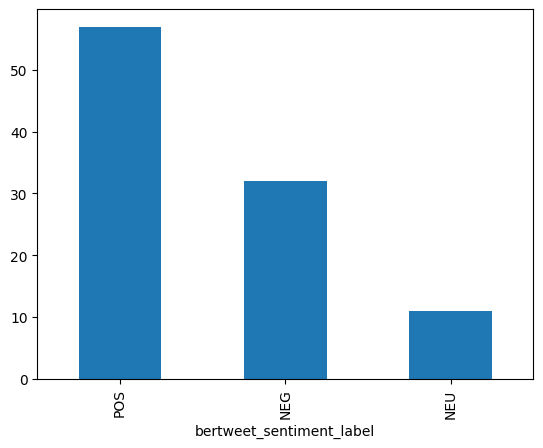

In [24]:
data['bertweet_sentiment_label'].value_counts().plot.bar()

## What I Learned

- Preprocessing (lowercase + punctuation removal) is essential before any NLP model

- VADER is fast and interpretable, but rule-based. Transformers (like BERT) offer deeper context understanding, but are slower and more resource-intensive.

- Both models give probabilistic sentiment, but Transformers usually return Positive and Negative, not Neutral.

- Bertweet Sentiment Model was able to recoginize Neutral as well.